In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip -u '/content/drive/MyDrive/classical-music-midi.zip' -d '/content/drive/MyDrive/music/'

In [ ]:
!dir /content/drive/MyDrive/music/

Albeniz    Borodin	Christmas  Granados  Mendelssohn  Rachmaninoff	Sinding
Bach	   Brahms	Clementi   Grieg     Moszkowski   Ravel		Tchaikovsky
Balakirev  Burgmueller	Debussy    Haydn     Mozart	  Schubert
Beethoven  Chopin	Godowsky   Liszt     Mussorgsky   Schumann


In [ ]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install --upgrade music21
!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore
!apt-get install xvfb

In [ ]:
# установим библиотеку для извлечения данных из MIDI
!pip install pretty_midi

In [ ]:
# Импортируем библиотеки
import tensorflow
import os
import numpy as np
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import fluidsynth

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import keras.backend as K


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [ ]:
from music21 import *

# настраиваем окружение в соответствии с документацией
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'

In [ ]:
CLASS_LIST=["Chopin", "Mozart"]

all_midis = []
for compositor in CLASS_LIST:
    filepath = f"/content/drive/MyDrive/music/{compositor}/"
    for i in os.listdir(filepath):
        if i.endswith(".mid"):
            tr = filepath+i

            # чтение и парсинг midi-файлов в Stream-объект библиотеки music21
            midi = converter.parse(tr)
            all_midis.append(midi)


Список из `all_midis` состоит из объектов `Stream` библиотеки `music21`, который содержит - как аккорды, так и ноты, мы будем извлекать их в виде нот и получать последовательность нот в музыкальной композиции.

In [ ]:
# функция для преобразования потока Stream midi-файлов в список нот
def getNotes(file):
    notes = []
    notes_to_parse = None
    for j in file:

        # получение инструментов из Stream-объекта
        songs = instrument.partitionByInstrument(j)

        # цикл по всем инструментам
        for part in songs.parts:
            # используем рекурсивный итератор в соответствии с документацией
            notes_to_parse = part.recurse()
            # части Stream-объекта, с которым мы работает состоит из разных элементов
            # отберем только интересующие нас элементы note.Note (нота) и chord.Chord (целый аккорд, последовательность нот)
            for element in notes_to_parse:
                if isinstance(element, note.Note):
                    # извлекаем ноту как тон (терминология библиотеки)
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    # аккорд функционирует как объект-нота, но имеет несколько последовательных тонов
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes

In [ ]:
Corpus = getNotes(all_midis)
print("Всего нот во всех midi-файлах всего датасета:", len(Corpus))

Всего нот во всех midi-файлах всего датасета: 113696


In [ ]:
# Функция преобразования отрывка из корпуса обратно в поток
def chords_n_notes(chunk):
    Melody = []
    offset = 0 # счетчик
    for i in chunk:
        # Если это аккорд разделенный точкой
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") # Разделяем аккорд на части
            notes = []
            for j in chord_notes:
                inst_note=int(j)
                # Преобразуем ноту в обект Note (нота)
                note_chunk = note.Note(inst_note)
                notes.append(note_chunk)
                # объединяем ноты в аккорды
                chord_chunk = chord.Chord(notes)
                # задаем позицию аккорда
                chord_chunk.offset = offset
                Melody.append(chord_chunk)
        # если это нота, а не аккорд
        else:
            # из текстового обозначения ноты делаем объект Note (ноту)
            note_chunk = note.Note(i)
            # задаем позицию ноты
            note_chunk.offset = offset
            Melody.append(note_chunk)
        # увеличиваем номер позиции
        offset += 1


    return Melody

# Преобразуем последовательность из 100 нот обратно в поток Stream
Music = chords_n_notes(Corpus[:100])
Melody_midi = stream.Stream(Music)

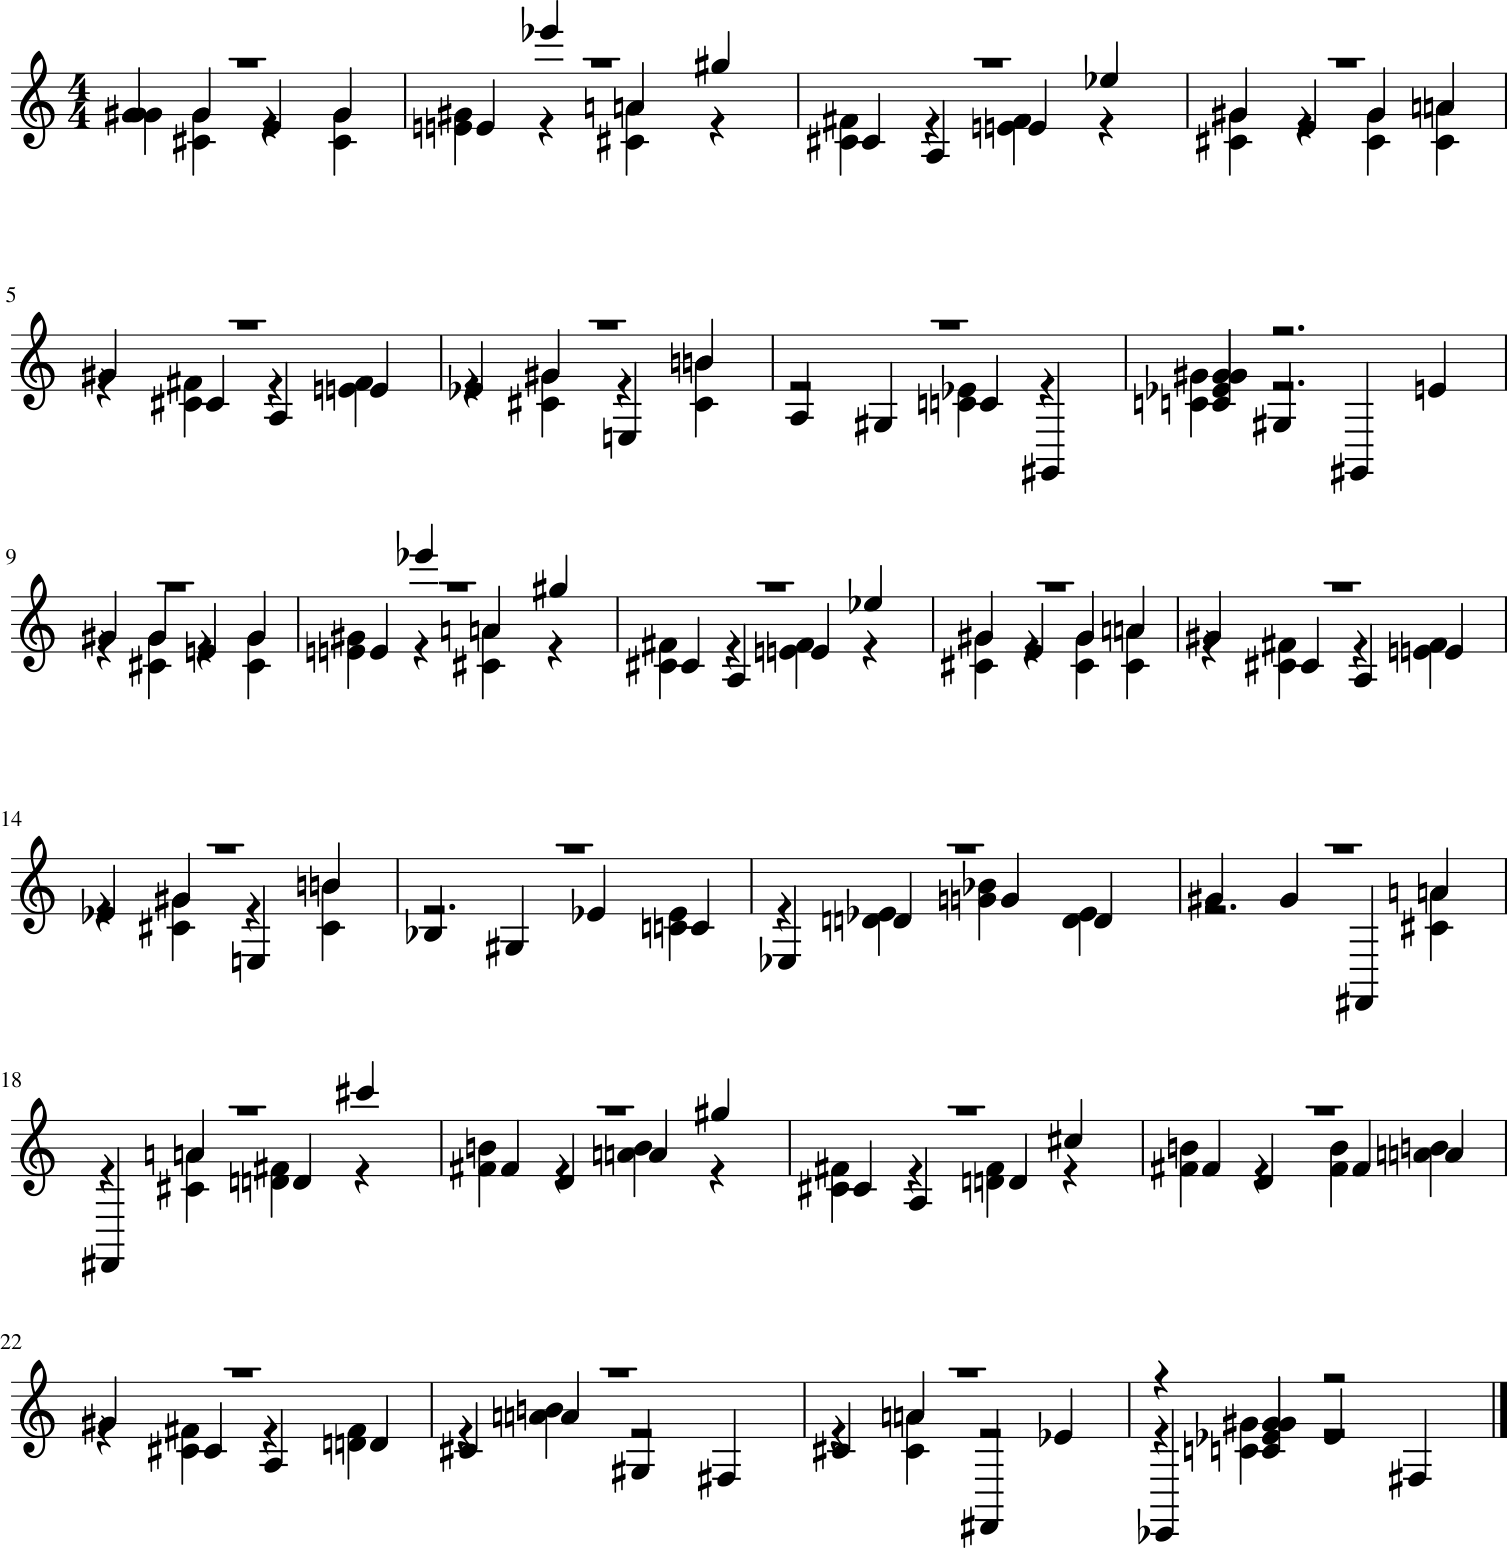

In [ ]:
# Отобразим нотный стан
Melody_midi.show()

In [ ]:
# импортируем загруженную библиотеку для работы с MIDI
import pretty_midi
# функция преобразования MIDI в DataFrame, содержащий ноты и их расширенные параметры
def midi_to_notes(midi_file: str):
  # чтение MIDI
  pm = pretty_midi.PrettyMIDI(midi_file)
  # извлечение первого инструмента
  instrument = pm.instruments[0]

  # объявляем список для хранения нот
  notes = []
  # сортируем ноты по времени начала ноты
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)

  # переменная для расчета шага, хранит предущее значение start
  prev_start = sorted_notes[0].start # начало первой ноты

  for note in sorted_notes:
    # начало ноты
    start = note.start
    # конец ноты
    end = note.end
    notes.append(
        dict(
            pitch=note.pitch,
            step=(start - prev_start),
            duration=(end - start),
            start=start
        )
    )

    prev_start = start # запоминаем значение предыдущего старта

  return pd.DataFrame(notes) # функция возвращает значение DataFrame библиотеки pandas

In [ ]:
# Выбор произвольного MIDI файла
filepath = f"/content/drive/MyDrive/music/Mozart/mz_311_1.mid"

# Преобразуем в ноты с расширенными параметрами
raw_notes = midi_to_notes(filepath)

# Вывод первых 5 строк
raw_notes.head()

,pitch,step,duration,start
0,66,0.000000,0.423042,0.000000
1,74,0.000000,0.423042,0.000000
2,69,0.000000,0.423042,0.000000
3,79,0.846084,0.111615,0.846084
4,78,0.101468,0.111615,0.947552


In [ ]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['F#4', 'D5', 'A4', 'G5', 'F#5', 'E5', 'F#5', 'A5', 'G5', 'F#5'],
      dtype='<U3')

In [ ]:
# Число уникальных нот в корпусе
from collections import Counter
count_num = Counter(Corpus)
print("Общее число уникальных нот в корпусе:", len(count_num))

Общее число уникальных нот в корпусе: 408


In [ ]:
# Распределение нот в корпусе
# Ключ в словаре - имена нот
# Значение в словаре - их количество

Notes = list(count_num.keys())
Recurrence = list(count_num.values())

# Средняя частота встречаемости нот в корпусе
def Average(rec):
    return sum(rec) / len(rec)

print('Средняя повторяемость ноты:', Average(Recurrence))
print('Наиболее часто встречаемые ноты:', max(Recurrence), 'раз')
print('Наиболее редкие ноты:', min(Recurrence), 'раз')

Средняя повторяемость ноты: 278.6666666666667
Наиболее часто встречаемые ноты: 3236 раз
Наиболее редкие ноты: 1 раз


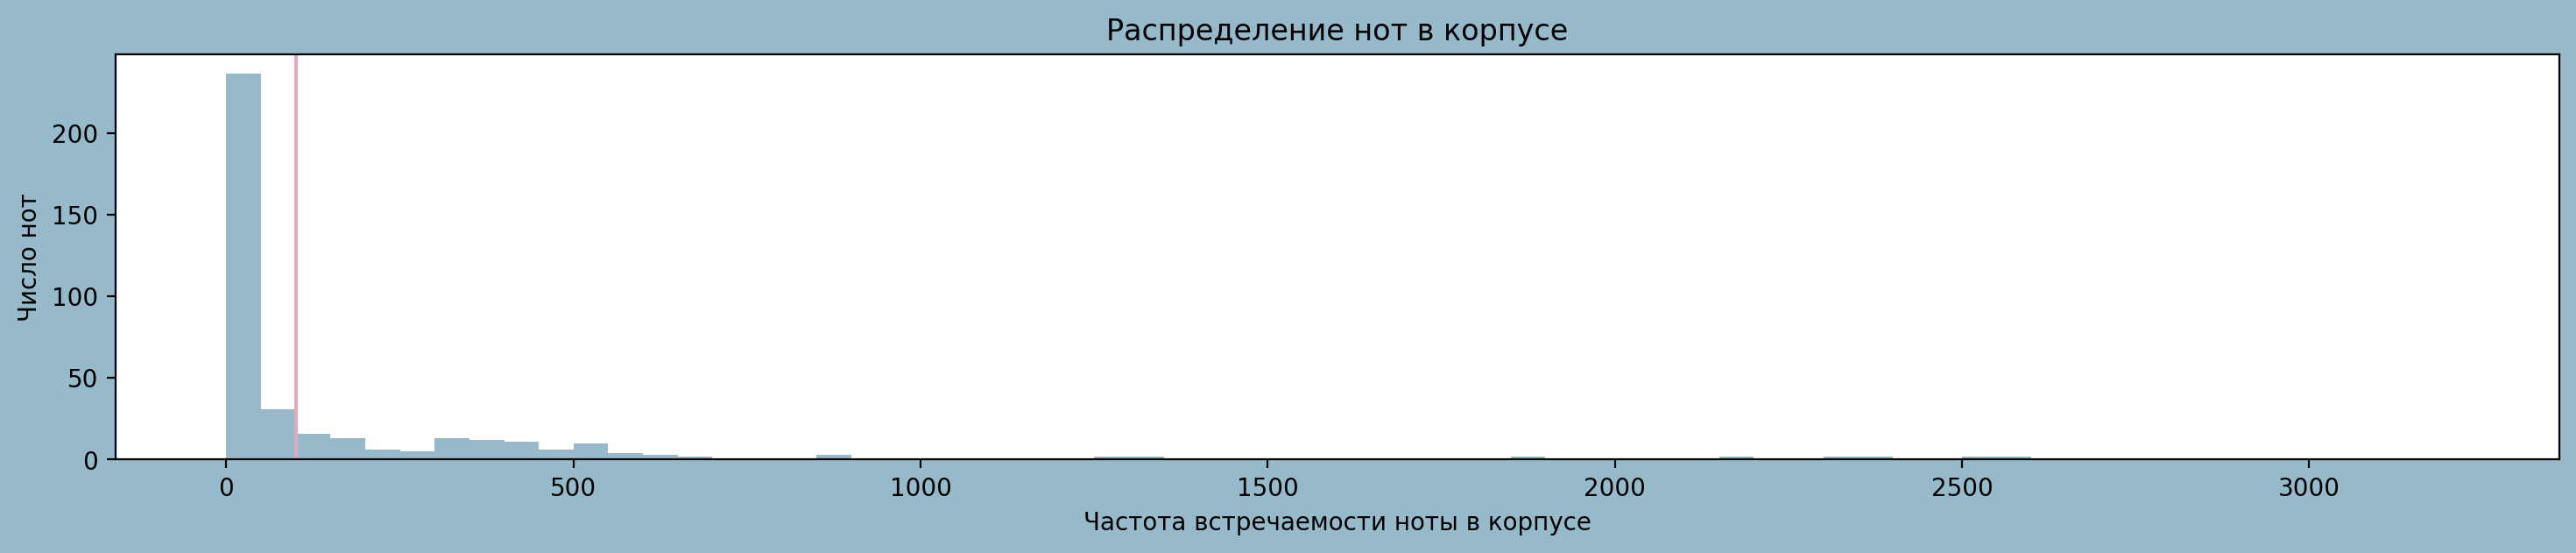

In [ ]:
# Распределение нот в корпусе график
plt.figure(figsize=(18, 3), facecolor='#97BACB')
bins = np.arange(0,(max(Recurrence)), 50)
plt.hist(Recurrence, bins=bins, color='#97BACB')
plt.axvline(x=100, color='#DBACC1') # отсечка по встречаемости в 100 раз
plt.title('Распределение нот в корпусе')
plt.xlabel('Частота встречаемости ноты в корпусе')
plt.ylabel('Число нот')
plt.show()

In [ ]:
# Будем избавляться от нот, которые встретились менее 100 раз.
# Получение списка редких нот
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)

print("Общее число нот, которые повторяются менее 100 раз:", len(rare_note))

Общее число нот, которые повторяются менее 100 раз: 267


In [ ]:
# Удаление редких нот
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Длина корпуса после исключения редких нот:", len(Corpus))

Длина корпуса после исключения редких нот: 109510


In [ ]:
# Сохраняем все уникальные значения корпуса
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) # длина корпуса
L_symb = len(symb) # число уникальных элементов корпуса

# Создание словаря для доступа к словарному запасу из индексов и наоборот
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Общее число символов:", L_corpus)
print("Число уникальных символов:", L_symb)

Общее число символов: 109510
Число уникальных символов: 261


In [ ]:
# Разбиение корпуса на равные входные строки и выходные целевые последовательности

# длинны последовательностей
length = 40

# входные последовательности
features = []

# целевые последовательности
targets = []

# цикл разбиения корпуса
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])


L_datapoints = len(targets)
print("Общее количество последовательностей в корпусе:", L_datapoints)

Общее количество последовательностей в корпусе: 109470


In [ ]:
# Нормализация данных
# Формирование входных данных X и выходных данных y с учетом всех трех переменных
X = np.zeros((L_datapoints, length, 3))  # Трехмерный массив для хранения pitch, step и duration
y = np.zeros((L_datapoints, L_symb))  # Одномерный массив для предсказания следующей ноты

# Заполнение X и y
for i, sequence in enumerate(features):
    for j, index in enumerate(sequence):
        X[i, j, :] = np.array([raw_notes.iloc[index]['pitch'], raw_notes.iloc[index]['step'], raw_notes.iloc[index]['duration']])
    y[i, targets[i]] = 1  # one-hot encoding для выходных данных

print(f'Форма входных данных: {X.shape}')
print(f'Форма выходных данных: {y.shape}')

Форма входных данных: (109470, 40, 3)
Форма выходных данных: (109470, 261)


In [ ]:
# Разделение выборки на тренировочные и начальные данные.
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from keras.optimizers import Adam
# Архитектура сети
model = Sequential()

model.add(LSTM(256, input_shape=X.shape[1:], return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(128))
model.add(Dense(128))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['acc'])


model.summary()

history = model.fit(X_train, y_train, batch_size=256, epochs=150)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 256)           266240    
                                                                 
 dropout (Dropout)           (None, 40, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 261)               33669     
                                                                 
Total params: 513541 (1.96 MB)
Trainable params: 513541 

In [ ]:
model.save('model_composers.keras')

In [ ]:
from keras.models import load_model

# Загрузка сохраненной модели
loaded_model = load_model('model_composers.keras')

# Продолжение обучения
history_continued = loaded_model.fit(X_train, y_train, batch_size=256, epochs=200)


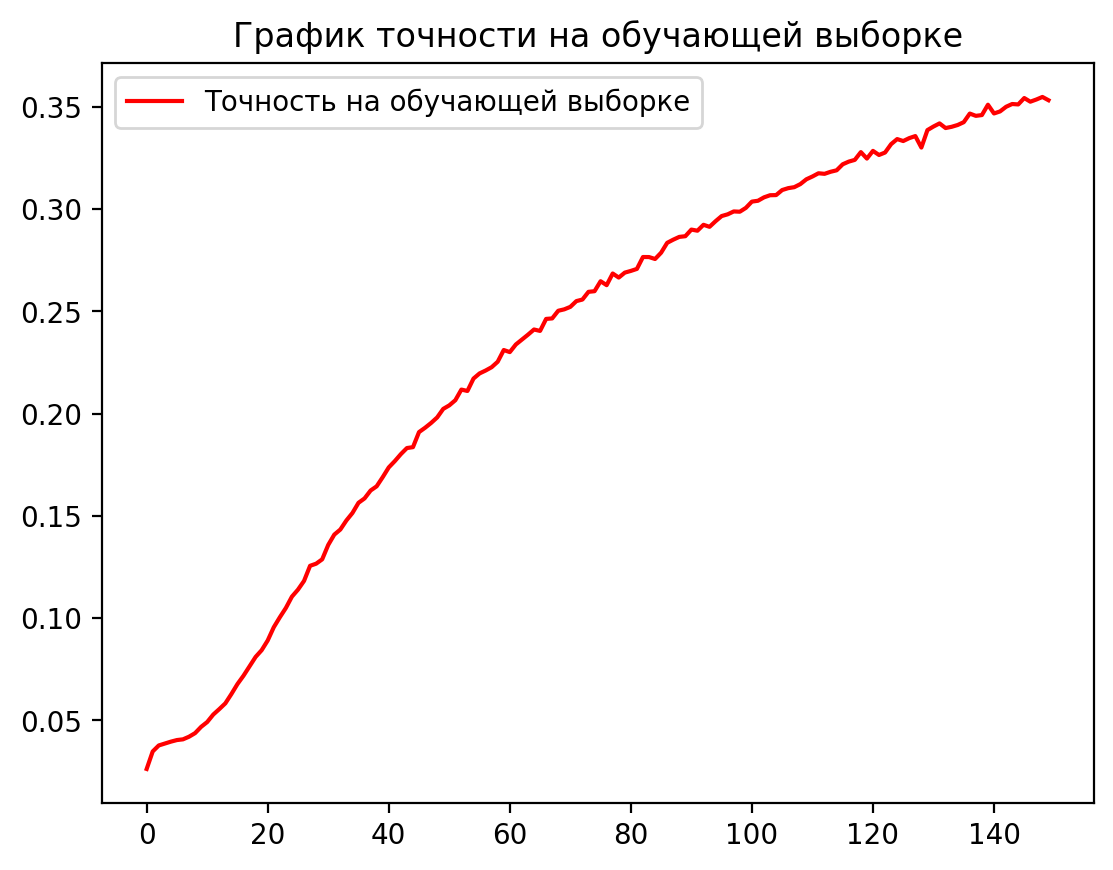

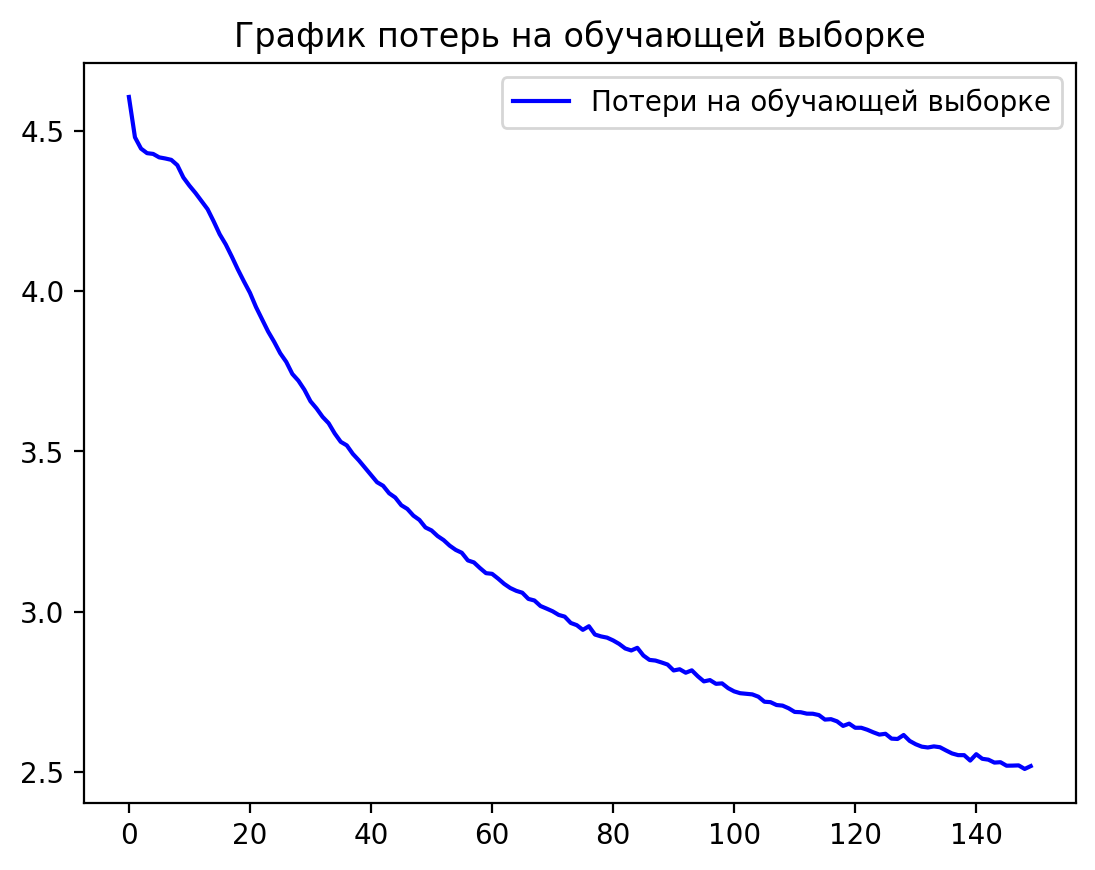

In [ ]:
plt.plot(history.epoch, history.history['acc'], 'r', label='Точность на обучающей выборке')
plt.title('График точности на обучающей выборке')
plt.legend()
plt.figure()
plt.plot(history.epoch, history.history['loss'], 'b', label='Потери на обучающей выборке')
plt.title('График потерь на обучающей выборке')
plt.legend()
plt.show()

In [ ]:
def music_generator(seq_len, temperature=3.0):
    # случайный выбор начальной последовательности
    seed = X_seed[np.random.randint(0, len(X_seed)-1)]
    music = []
    notes = []
    for i in range(seq_len):
        # изменяем размер данных для передачи модели
        seed = seed.reshape(1, length, 3)

        # предсказываем по начальной последовательности
        prediction = model.predict(seed, verbose=0)[0]

        # применяем температуру к предсказаниям и применяем softmax
        prediction = np.log(prediction) / temperature
        # предсказанные значения прогоняем через функцию softmax
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)

        # выбираем индекс наиболее вероятного класса
        index = np.argmax(prediction)

        # нормализованный индекс в интервале [0, 1]
        # значение пойдет в seed, а там все значения в интервале [0, 1]
        index_N = index / float(L_symb)

        # складываем в список индекс предсказанной ноты
        notes.append(index)

        # обратное преобразование по словарю, на выходе последовательность нот
        music = [reverse_mapping[char] for char in notes]

        # seed всегда длины length
        # добавляем справа новое значение, а слева удаляем и уходим на новую итерацию цикла
        seed = np.insert(seed[0], len(seed[0]), index_N)
        seed = seed[1:]

    return chords_n_notes(music)


In [ ]:
genMusic = music_generator(100)
genMidi = stream.Stream(genMusic)

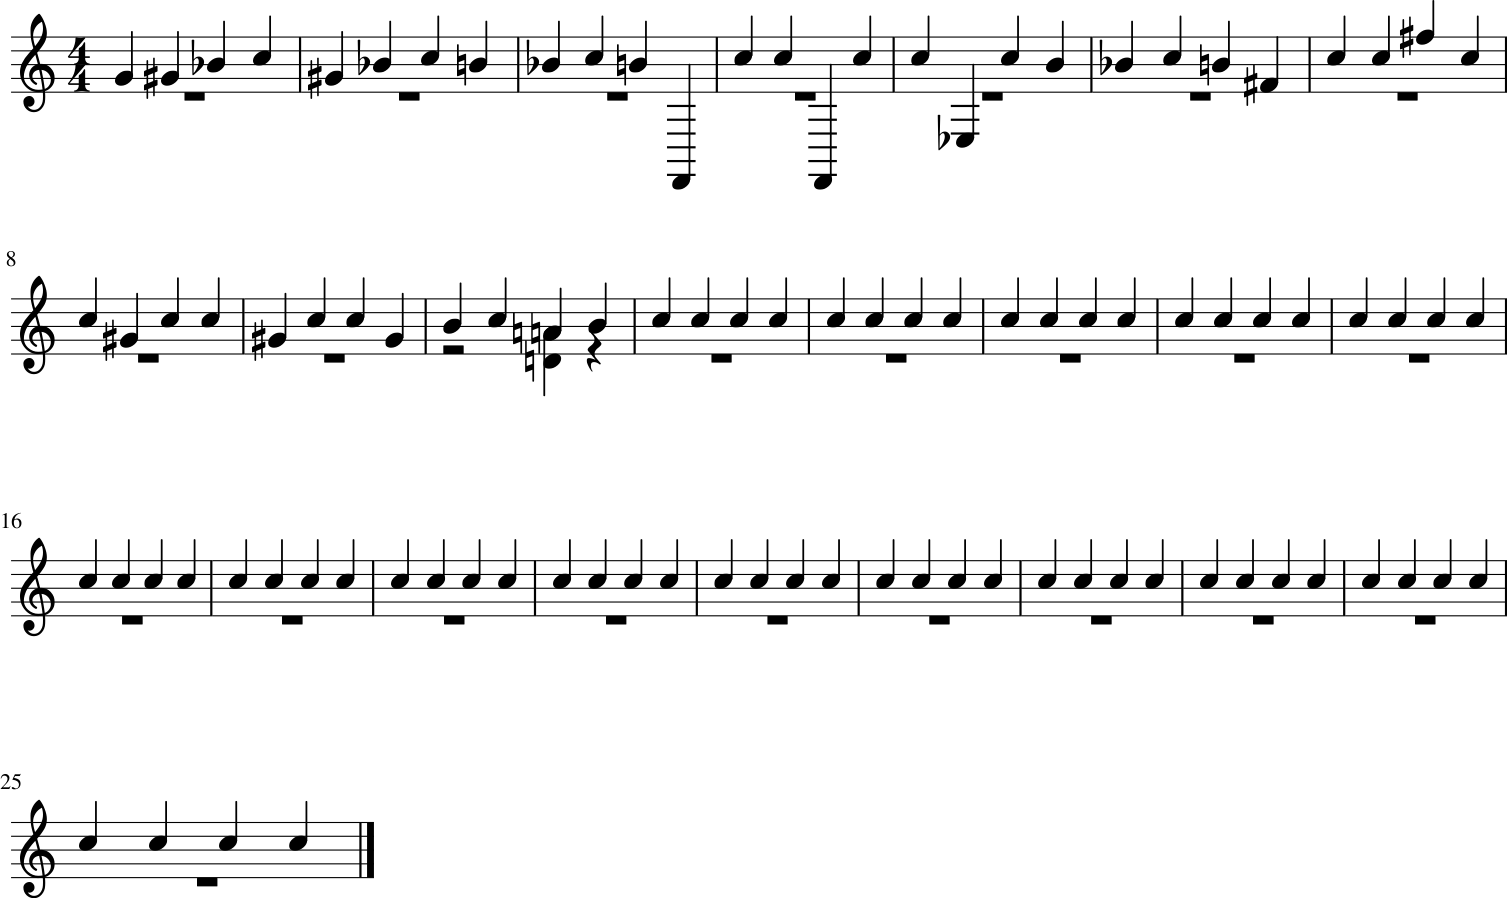

In [ ]:
# Отобразим нотный стан
genMidi.show()

In [ ]:
# Выведем в виде звуковой дорожки
genMidi.show('midi')